# 自作ガウシアン

In [1]:
def gauss(x, a, mu, si, nf):
    """
    a: 最大値
    mu: 位置
    si: 線幅
    noisef: 最低値
    """
    return a * np.exp(-(x - mu)**2 / 2 / si**2) + nf

In [2]:
nf=0.5
n=1001
x = np.linspace(0,100,n)
a, mu, si = 1, 50, 1

In [3]:
g= gauss(x, a, mu, si, nf); g

array([ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5])

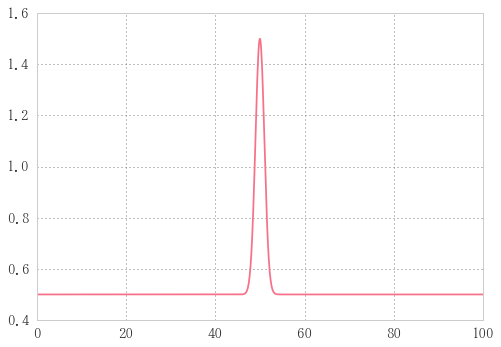

In [4]:
plt.plot(x, g)

## 自作ガウシアンじゃなくてscipy.stats.normを使うべきでは

In [9]:
from  scipy.stats import norm

In [10]:
z=norm.pdf(x, loc=50, scale=1)-0.5; z

array([-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5])

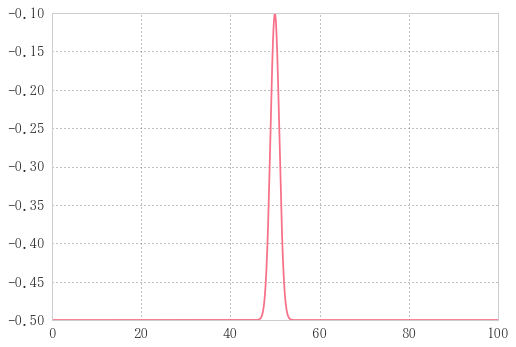

In [11]:
plt.plot(x,z)

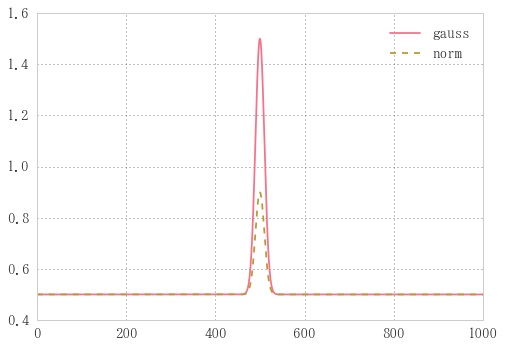

In [37]:
a, mu, si=1, 50, 1
df=pd.DataFrame({'norm': a*norm.pdf(x, loc=mu, scale=si)+nf,
                 			'gauss': gauss(x, a, mu, si, nf)})
df.plot(style=['-', '--'])

## norm vs my_gauss
normでも自作gaussでも中でnp使っているんで実行速度あんま変わらないだろうとテスト

In [38]:
%timeit gauss(x, a, mu, si)

The slowest run took 5.79 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 59.8 µs per loop


In [21]:
%timeit norm.pdf(x, loc=50, scale=1)-0.5

The slowest run took 5.26 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 218 µs per loop


自作ガウスのほうが早い…！

## ガウシアンに沿ってノイズを作る

ということで自作のガウシアンを使っていきます。

In [5]:
g = gauss(x, a, mu, si, 0.5)
gnoise = g + 0.1 * g * np.random.randn(n)

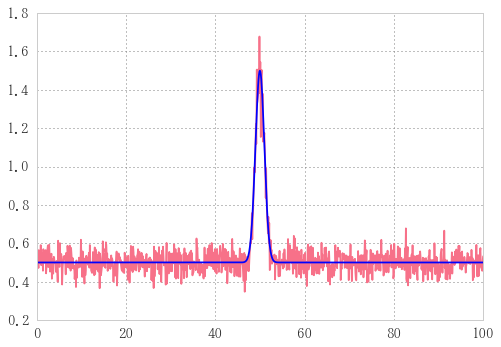

In [6]:
plt.plot(x, gnoise, '-')
plt.plot(x, g,'b-' )

ノイズを発生させる

## カーブフィッティングをかけて、ノイズをフィッティングする

gからgnoiseを導き出したのだけれども、ここで急にgを未知の関数とみなしてしまう。
今あなたはgnoiseだけを知っていて、gのような関数を得たいとき、どうするか。

こういう時はカーブフィットを取る。
scipy.optimizeからcurve_fitをインポートしてくる。

In [9]:
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import scoreatpercentile

次にフィッティングパラメータを定める。

In [56]:
(a_, mu_, si_, nf_), _ = curve_fit(gauss, x, gnoise, p0=(a, mu, si, nf))
yfit = gauss(x, a_, mu_, si_, nf)  # フィッティングにより導き出されたa,mu,siを代入
print('元パラメータ:%s\nフィッティングで求めたパラメータ: %s' % ((a, mu , si), (a_, mu_, si_)))

元パラメータ:(1, 50, 1)
フィッティングで求めたパラメータ: (0.98288835192385138, 49.983822066353746, 0.99222230410189216)


In [28]:
_

array([[  2.69528582e-04,   1.34053555e-10,  -1.71228319e-04,
         -2.27783859e-06],
       [  1.34053555e-10,   3.40470185e-04,  -1.30160080e-10,
         -1.16627832e-14],
       [ -1.71228319e-04,  -1.30160080e-10,   3.46610735e-04,
         -4.44756457e-06],
       [ -2.27783859e-06,  -1.16627832e-14,  -4.44756457e-06,
          3.22135030e-06]])

curve_fitの戻り値アンダーバーは共分散？

    pcov : 2d array
    The estimated covariance of popt. The diagonals provide the variance
    of the parameter estimate. To compute one standard deviation errors
    on the parameters use ``perr = np.sqrt(np.diag(pcov))``.

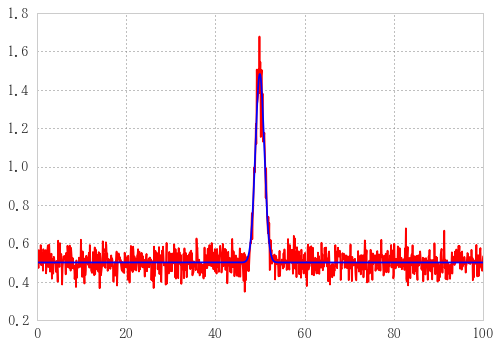

In [57]:
plt.plot(x, gnoise, 'r-')
plt.plot(x, yfit, 'b-') 

さっきと同じグラフに見えるが、描いているのはgではなくyfitであることに注意

同じグラフに見えるということはフィッティングできたということ。

# scipy.stats.normを使った場合

## ガウシアンに沿ってノイズを作る

In [19]:
from  scipy.stats import norm

In [53]:
n=1001
xx = np.linspace(0,100,n)
aa, mu, si = 5, 50, 1

In [57]:
def gauss2(x, a, mu, si):
    return a*norm.pdf(x, loc=mu, scale=si)-noisef

In [58]:
g = gauss2(xx, aa, mu, si)
gnoise = g + 0.1 * np.random.randn(n)

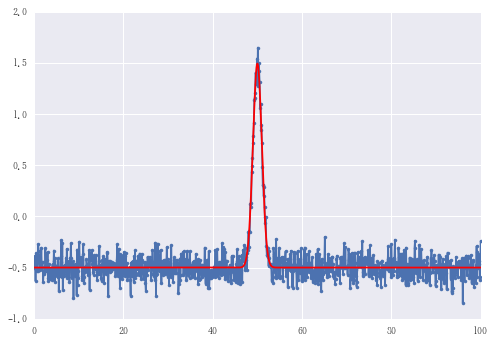

In [59]:
plt.plot(xx, gnoise, '.-')
plt.plot(xx, g,'r-' )

## カーブフィッティングをかけて、ノイズをフィッティングする

gからgnoiseを導き出したのだけれども、ここで急にgを未知の関数とみなしてしまう。
今あなたはgnoiseだけを知っていて、gのような関数を得たいとき、どうするか。

In [66]:
from scipy.optimize import curve_fit
(aa_, mu_, si_), _ = curve_fit(gauss2, xx, gnoise, (aa, mu, si))
yfit = gauss2(xx,aa_, mu_, si_)

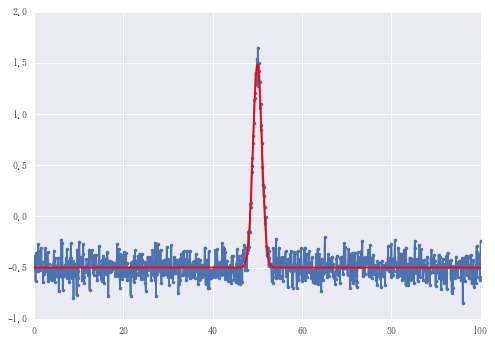

In [67]:
plt.plot(xx, gnoise, '.-')
plt.plot(xx, yfit, 'r-')  # 描いているのはgではなく、yfitであることに注意

ちゃんとフィッティングできた。

# 自作ガウスをノイズのあるデータフレームにcarve_fitをapply

## ランダムデータフレームの作成

In [12]:
r=np.random

いっぱい使うから乱数生成をrに縮めちゃう

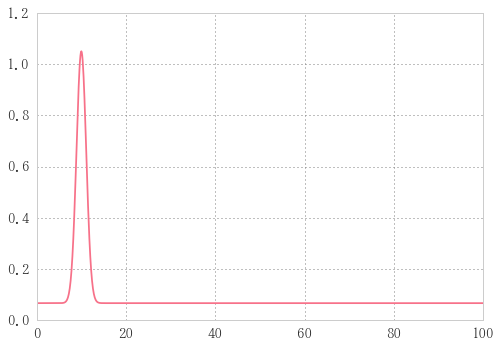

In [13]:
g = gauss(x, a=r.rand(), mu=10*1, si=10*r.rand(), nf=nf*r.rand())
plt.plot(x, g)

ランダムな値を使って発生させたガウシアン

In [8]:
%%timeit
df = pd.DataFrame([], index=range(1000))
for i in np.arange(min(x), max(x), 10):
    g = gauss(x, a=r.rand(), mu=i, si=10*r.rand(), noisef=nf)
    df[i] = pd.DataFrame(g)

100 loops, best of 3: 8.69 ms per loop


まず思いつくforループ

In [12]:
%%timeit
garray = np.array([gauss(x, a=r.rand(), mu=i, si=10*r.rand(), noisef=nf)
                    for i in np.arange(min(x), max(x), 10)]).T
df = pd.DataFrame(garray)

1000 loops, best of 3: 743 µs per loop


リスト内包表記を使うことでより高速

In [14]:
%%timeit
xa = np.tile(x, (10,1))
aa = abs(r.randn(10))
mua = np.arange(min(x), max(x), 10)
sia = 10 * abs(r.randn(10))

df = pd.DataFrame(gauss(xa.T, aa, mua, sia, nf))

1000 loops, best of 3: 604 µs per loop


np.arrayで変数作るともっともっと高速

In [20]:
xa = np.tile(x, (10,1))
aa = abs(r.randn(10))
mua = np.arange(min(x), max(x), 10)
sia = 10 * abs(r.randn(10))

df = pd.DataFrame(gauss(xa.T, aa, mua, sia, nf))

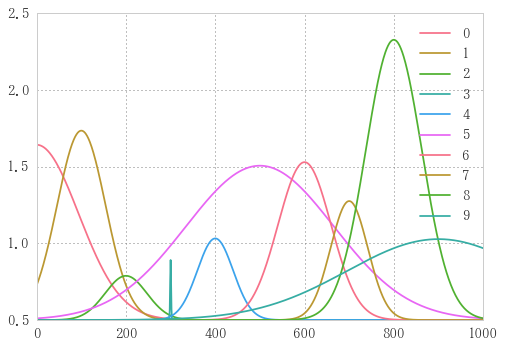

In [21]:
df.plot()

様々な形のガウシアン。

ノイズフロアは一定にした。

こいつらにノイズを載せる。

## ランダムデータフレームにノイズのせてサンプルデータ作成

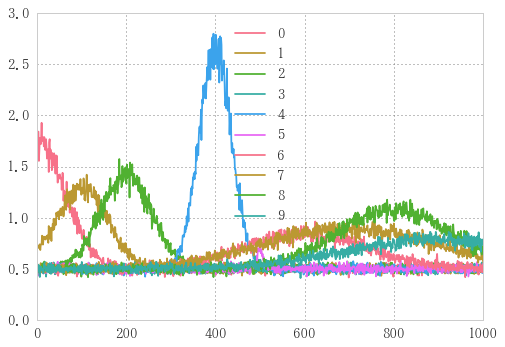

In [22]:
noisedf =df + df * 0.05 * r.randn(*df.shape)
noisedf.plot()

5%のノイズをのせた。
`np.randn(*df.shape)`でデータフレームと同じ行列を持ったランダムデータフレームを生成させている。
スターを`df.shape`の前につけてタプルを展開して`randn`に渡す。

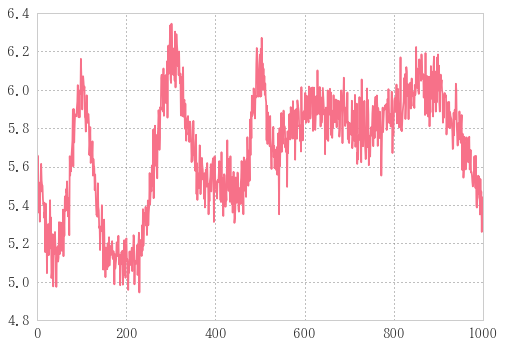

In [90]:
sumdf = noisedf.sum(axis=1)
sumdf.plot()

In [85]:
sumdf

0       5.432676
1       5.605698
2       5.298539
3       5.522210
4       5.598536
5       5.628876
6       5.590488
7       5.520159
8       5.357040
9       5.524325
10      5.352305
11      5.252700
12      5.442083
13      5.357631
14      5.633205
15      5.394023
16      5.485547
17      5.300434
18      5.472389
19      5.403377
20      4.983068
21      5.330210
22      5.274541
23      5.166913
24      5.551668
25      5.476331
26      5.108893
27      4.984221
28      5.214877
29      5.402299
          ...   
971     5.363341
972     5.478791
973     5.665920
974     5.777761
975     5.737976
976     5.659097
977     5.625246
978     5.545209
979     5.726983
980     5.747878
981     5.479815
982     5.714544
983     5.406541
984     5.325538
985     5.532115
986     5.222370
987     5.502674
988     5.481744
989     5.548988
990     5.690841
991     5.502521
992     5.599736
993     5.366537
994     5.508551
995     5.497639
996     5.128502
997     5.403535
998     5.3501

indexはそのままにカラムをすべて足す。この中でindexいくつの位置にガウシアンが立つかを調べる。

## 複数のランダムウェーブを生成

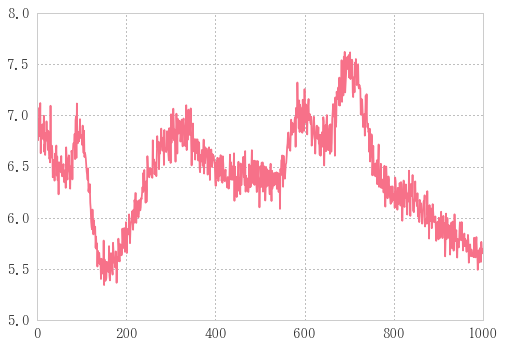

In [4]:
def waves(seed: int=np.random.randint(100)):
    """ランダムノイズを発生させたウェーブを作成する
    引数: seed: ランダムステートを初期化する整数。デフォルトでseedをランダムに発生させる
    戻り値: noisedf.sum(1): pd.Series型"""
    r = np.random
    r.seed(seed)  # ランダム初期化
    xa = np.tile(x, (10,1))
    aa = abs(r.randn(10))
    mua = np.arange(min(x), max(x), 10)
    sia = 10 * abs(r.randn(10))

    df = pd.DataFrame(gauss(xa.T, aa, mua, sia, nf))
    noisedf = df + df * 0.05 * r.randn(*df.shape)
    return noisedf.sum(1)
waves().plot()

In [147]:
%timeit waves()

100 loops, best of 3: 2.33 ms per loop


In [5]:
df = pd.DataFrame([waves(i) for i in range(10)]); df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,6.945187,7.108197,6.845565,6.948541,6.845199,7.055347,6.977616,7.056927,7.079365,7.138362,...,5.352165,5.237588,5.368697,5.147199,5.197124,5.213663,5.317618,5.263670,5.266836,5.319199
1,7.133442,7.059512,7.190294,7.232617,7.261932,7.016845,7.189088,7.295845,7.185489,7.022073,...,5.166897,5.017208,5.075220,5.214620,5.136346,5.049252,5.014033,5.049660,5.022505,5.217068
2,5.348248,5.553449,5.548598,5.538164,5.430301,5.412686,5.579073,5.552572,5.647116,5.415833,...,5.104680,5.207193,5.014641,5.061536,5.125885,5.072221,5.181555,4.908350,5.057412,5.102178
3,7.274488,7.426611,7.076638,7.595002,7.723684,7.506426,7.210183,7.406186,7.584276,7.486866,...,5.332370,5.272767,5.421780,5.499642,5.210076,5.363444,5.385211,5.220253,5.466960,5.286162
4,5.086649,5.070892,5.054293,5.011917,5.164769,5.146161,4.921866,5.057269,5.123093,5.084757,...,5.065826,5.150936,5.078083,5.028696,5.064742,5.037380,5.331177,5.131369,5.206482,5.235898
5,5.380750,5.546886,5.502097,5.557626,5.416009,5.364240,5.585252,5.475956,5.528495,5.392496,...,5.354433,5.439949,5.550969,5.281462,5.491426,5.382127,5.453180,5.208387,5.277590,5.423068
6,5.629440,5.443759,5.531657,5.720805,5.500641,5.665483,5.582582,5.677595,5.435612,5.648220,...,5.288703,5.109035,5.229636,5.267676,5.134689,5.277698,5.236259,5.066652,5.206823,5.181833
7,6.827328,6.582126,6.744212,6.905696,6.514176,6.890059,6.824137,6.794166,6.634765,6.680948,...,5.532310,5.495926,5.500994,5.431254,5.448915,5.520323,5.463009,5.670345,5.523788,5.370447
8,6.417707,6.429011,6.475284,6.290368,6.670582,6.636257,6.427363,6.455692,6.620168,6.508548,...,4.998059,4.907901,4.900991,4.984814,5.011483,4.939173,5.053548,4.868739,4.874232,4.905128
9,5.285603,5.404935,5.279550,5.060339,5.276347,5.236848,5.305694,5.347108,5.337980,5.361805,...,5.626433,5.572625,5.647371,5.480810,5.495603,5.535284,5.492852,5.550408,5.592165,5.344825


# データフレームに一斉にフィッティングかける
一番やりたかったこと　ここから。

## 試しに波を一つ選んでfitting

### 特定範囲を抽出する関数を作成

In [6]:
def choice(array, center, span):
    """特定の範囲を抜き出す
    引数: 
        array: 抜き出し対象のarrayっぽいの(arraylike)
        center: 抜き出し中央(float)
        span: 抜き出しスパン(float)
    戻り値:
        rarray:
    """
    x1 = int(center - span / 2)
    x2 = int(center + span / 2)
    return array[x1:x2]

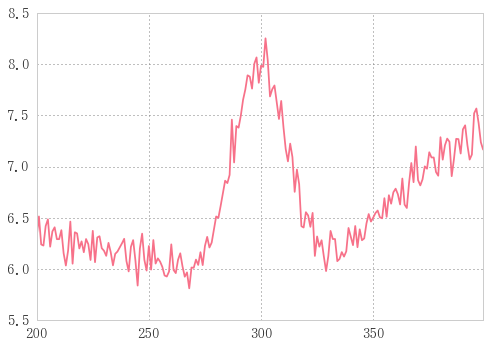

In [7]:
ch = (300, 200)  # 中央値300でスパン200で取り出したい
df0 = choice(df.iloc[0], *ch)
df0.plot()

### 一つの波をfitting

In [10]:
param = (a, mu, si, nf) = 5, 300, 3, scoreatpercentile(df0, 25)
param

(5, 300, 3, 6.1943784193082427)

パラメータ再設定

In [11]:
fitx, fity = df0.index, df0.values,
popt, _pcov = curve_fit(gauss, np.array(fitx), fity, p0=param)
print('a, mu, si, nf = ', popt)

a, mu, si, nf =  [   1.64608234  299.80613945    8.94731799    6.44094237]


fittingの結果

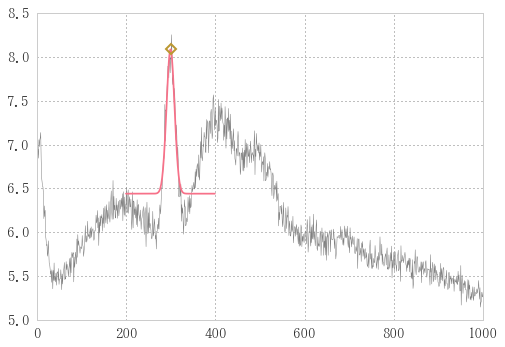

In [12]:
df.iloc[0].plot(color='gray', lw=0.5)
plt.plot(df0.index, gauss(df0.index, *popt))
plt.plot(popt[1], popt[0]+popt[3] , 'D', fillstyle='none', mew=2)

プロットするときは`mu`が横軸、　`a+nf`が縦軸

## df縦方向にfitting
axis=0方向にfitting

意味的には特定周波数を別時間軸上で同時に実行。
`df.apply(curve_fit, args=())`使いたい。

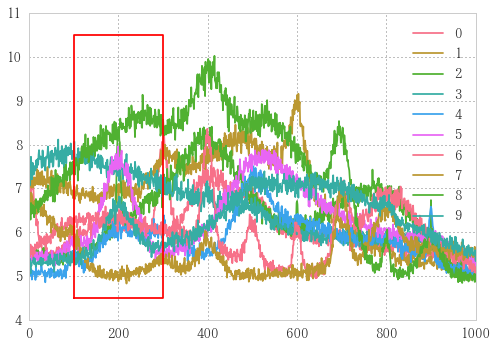

In [13]:
df.T.plot()
plt.plot((100,100, 300, 300, 100), (4.5, 10.5, 10.5, 4.5, 4.5), 'r-')  # 枠線

赤枠の中だけ拡大。(その中だけがフィッティング対象)

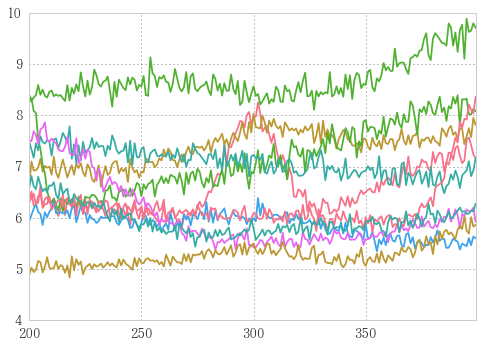

In [21]:
ch = (300, 200)
dfe = df.apply(choice,axis=1, args=ch)
dfe.T.plot(legend=False)

拡大した図

### fitting関数作成

In [22]:
fit = lambda x: curve_fit(gauss, x.index, x.values, p0=param)  # fitting function
fita = dfe.apply(fit, axis=1)

フィッティング関数はlambda式で定義して、
applyでデータフレームの各行に適用。

In [23]:
type(fita)

pandas.core.series.Series

In [24]:
fita

0    ([1.64608233941, 299.806139455, 8.94731798894,...
1    ([1.06720581454, 342.175948763, 77.8097497546,...
2    ([-1.86034853457, 247.618524866, 71.1429284505...
3    ([0.119213086912, 301.166378566, 1.38645305185...
4    ([603.417204075, 231.312304775, 3682.28745173,...
5    ([-8214.48961119, 324.777372988, 5187.93270244...
6    ([-10834.1282713, 288.175702378, 7442.99563502...
7    ([0.167421897449, 299.669427889, 11.8363393835...
8    ([-10855.5095368, 267.685530085, 9114.65805152...
9    ([-5964.08199733, 311.71632169, 6258.82944108,...
dtype: object

fitaはpandas.Seriesだが、一つの要素にタプル形式でフィッティングのパラメータと分散が入っている。

そこで以下のようにして内法表記で分解して第0要素だけ取り出す。

In [46]:
result = pd.DataFrame((i[0] for i in fita), columns=['a', 'mu', 'si', 'nf']); result

,a,mu,si,nf
0,1.646082,299.806139,8.947318,6.440942
1,1.067206,342.175949,77.809750,6.611884
2,-1.860349,247.618525,71.142928,8.390693
3,0.119213,301.166379,1.386453,7.093136
4,603.417204,231.312305,3682.287452,-597.375350
5,-8214.489611,324.777373,5187.932702,8219.951273
6,-10834.128271,288.175702,7442.995635,10840.016757
7,0.167422,299.669428,11.836339,5.240607
8,-10855.509537,267.685530,9114.658052,10863.926883
9,-5964.081997,311.716322,6258.829441,5969.772154


フィッティング結果のデータフレーム

In [54]:
result = np.array([i[0] for i in fita]); result

array([[  1.64608234e+00,   2.99806139e+02,   8.94731799e+00,
          6.44094237e+00],
       [  1.06720581e+00,   3.42175949e+02,   7.78097498e+01,
          6.61188409e+00],
       [ -1.86034853e+00,   2.47618525e+02,   7.11429285e+01,
          8.39069261e+00],
       [  1.19213087e-01,   3.01166379e+02,   1.38645305e+00,
          7.09313574e+00],
       [  6.03417204e+02,   2.31312305e+02,   3.68228745e+03,
         -5.97375350e+02],
       [ -8.21448961e+03,   3.24777373e+02,   5.18793270e+03,
          8.21995127e+03],
       [ -1.08341283e+04,   2.88175702e+02,   7.44299564e+03,
          1.08400168e+04],
       [  1.67421897e-01,   2.99669428e+02,   1.18363394e+01,
          5.24060726e+00],
       [ -1.08555095e+04,   2.67685530e+02,   9.11465805e+03,
          1.08639269e+04],
       [ -5.96408200e+03,   3.11716322e+02,   6.25882944e+03,
          5.96977215e+03]])

フィッティング結果のnp.array

### fitting結果を描く

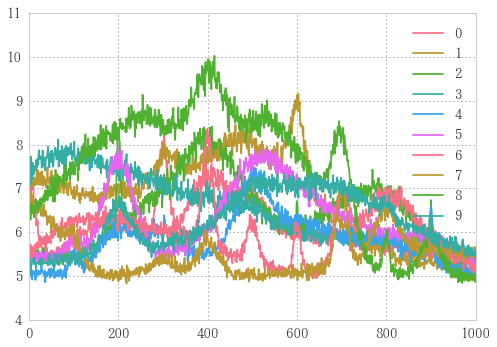

In [27]:
df.T.plot()

この上にfitting結果を重ねていく

fitting結果resultにapplyする関数を決定する。

横軸の値、縦軸の値を返す関数。

In [58]:
defit = lambda row: (row[1], row[0]+row[3])

In [38]:
result.columns

Index(['a', 'mu', 'si', 'nf'], dtype='object')

プロットするときは`mu`が横軸、　`a+nf`が縦軸

In [61]:
plt_pnt = np.apply_along_axis(defit, 1, result); plt_pnt

array([[ 299.80613945,    8.08702471],
       [ 342.17594876,    7.6790899 ],
       [ 247.61852487,    6.53034408],
       [ 301.16637857,    7.21234883],
       [ 231.31230478,    6.04185377],
       [ 324.77737299,    5.46166178],
       [ 288.17570238,    5.8884859 ],
       [ 299.66942789,    5.40802915],
       [ 267.68553009,    8.41734618],
       [ 311.71632169,    5.69015661]])

In [96]:
plt_pnt_se = pd.Series(plt_pnt.T[1], index=plt_pnt.T[0]); plt_pnt_se

299.806139    8.087025
342.175949    7.679090
247.618525    6.530344
301.166379    7.212349
231.312305    6.041854
324.777373    5.461662
288.175702    5.888486
299.669428    5.408029
267.685530    8.417346
311.716322    5.690157
dtype: float64

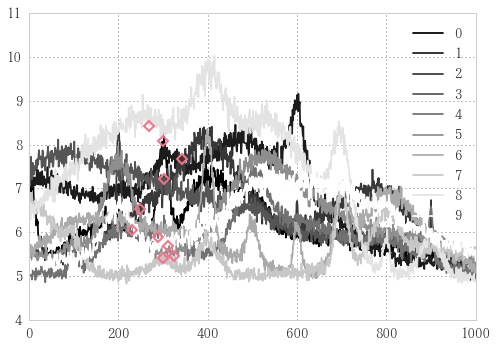

In [84]:
df.T.plot(cmap='gray')
plt_pnt_se.plot(style='D', mew=2, fillstyle='none')

# 特定周波数(axis=1方向)のfittingまとめ

## モジュール

In [1]:
from scipy.optimize import curve_fit
from scipy.stats import scoreatpercentile
r = np.random

## 関数

### ガウス関数

In [2]:
def gauss(x, a, mu, si, nf):
    """
    a: 最大値
    mu: 位置
    si: 線幅
    noisef: 最低値
    """
    return a * np.exp(-(x - mu)**2 / 2 / si**2) + nf

## パラメータ

In [3]:
param = a, mu, si = 5, 300, 3

### フィット関数

In [66]:
def fit(series, a, mu, si):
    """fitting function
    シリーズに対してガウシアンフィッティングを行う
    引数:
        a: 最大値
        mu: 位置
        si: 線幅
    戻り値:
        cf: フィッティング結果(エラーが起きたときはnp.nanのタプル)"""
    errcount = 0
    x, y =  series.index, series.values
    nf = scoreatpercentile(series, 25)
    cfshape = (4,)
    try:
        cf = curve_fit(gauss, x, y, p0=(a, mu, si, nf))
    except Exception as e:
        errcount += 1
        print('error', errcount, ':', e)  # エラー数, エラーメッセージの表示
        cf = np.full(cfshape, np.nan), np.nan  # エラー起きたらnan返す
    return cf

### デフィット関数

In [7]:
def defit(row):
    """return fitting result as plot point"""
    return row[1], row[0]+row[3]

### choice関数

In [8]:
def choice(array, center, span):
    """特定の範囲を抜き出す
    引数: 
        array: 抜き出し対象のarrayっぽいの(arraylike)
        center: 抜き出し中央(float)
        span: 抜き出しスパン(float)
    戻り値:
        rarray:
    """
    x1 = int(center - span / 2)
    x2 = int(center + span / 2)
    return array[x1:x2]

## データ

In [9]:
def waves(seed: int=np.random.randint(100), rows=10):
    """ランダムノイズを発生させたウェーブを作成する
    引数: seed: ランダムステートを初期化する整数。デフォルトでseedをランダムに発生させる
    戻り値: noisedf.sum(1): pd.Series型"""
    r = np.random
    r.seed(seed)  # ランダム初期化
    x = np.linspace(1, 10, 1001)
    xa = np.tile(x, (rows,1))
    aa = abs(r.randn(rows))
    mua = np.linspace(min(x), max(x), rows)
    sia = abs(r.randn(rows))
    nf = 0.01 * r.randn(rows)

    df = pd.DataFrame(gauss(xa.T, aa, mua, sia, nf))
    noisedf = df +  0.05 * r.randn(*df.shape)
    return noisedf.sum(1)

In [10]:
df = pd.DataFrame([waves(i) for i in range(10)]); df
df.index=pd.date_range('20160101', periods=len(df), freq='H')

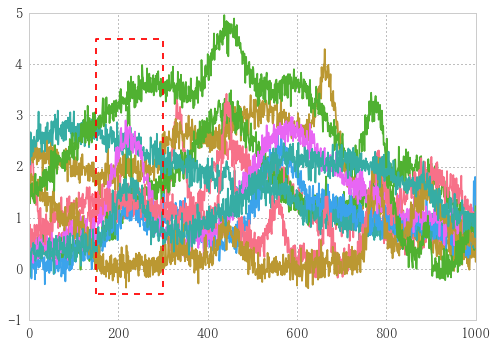

In [13]:
df.T.plot(legend=False)
# 枠線
w1, w2, h1, h2 = 150, 300, -.5, 4.5
plt.plot((w1,w1, w2, w2, w1), (h1, h2, h2, h1, h1), 'r--')

赤枠内をフィッティング

## フィッティング処理

In [92]:
ch = (220, 200)  # 中央値220でスパン200で取り出したい
dfe = df.apply(choice,axis=1, args=ch)  # 抜き出し
fita = dfe.apply(fit, axis=1, args=param)  # フィッティング
    
# フィッティング結果の整理
result = np.array([i[0] for i in fita])  # タプルの第一要素だけを取り出しarray化
plt_pnt = np.apply_along_axis(defit, 1, result)  # ポイントのプロットに必要な部分抜き出し
plt_pnt_se = pd.Series(plt_pnt.T[1], index=plt_pnt.T[0])  # fitting結果をseries化

error 1 : Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


In [93]:
result

array([[ -2.66132842e-01,   2.88736148e+02,   9.15963390e+00,
          1.22932384e+00],
       [  6.29053800e-01,   3.11584775e+02,   1.57575658e+01,
          1.90521197e+00],
       [  2.25524792e+00,   2.82022999e+02,   1.16582536e+02,
         -5.87482031e-01],
       [             nan,              nan,              nan,
                     nan],
       [  1.84837107e+00,   2.57369098e+02,   1.19955217e+02,
         -7.69991058e-01],
       [ -1.12784752e+00,   3.09939505e+02,   2.05845982e+01,
          1.69080069e+00],
       [ -2.75390973e-01,   3.04536318e+02,   3.17605280e+01,
          1.35006383e+00],
       [  1.88870239e-01,   3.22392036e+02,   1.21034501e+01,
          1.45666266e-01],
       [  1.14160133e+00,   2.82278675e+02,   8.91448753e+01,
          2.47223875e+00],
       [ -3.80732172e-01,   3.01482594e+02,   1.72303744e+01,
          1.04019927e+00]])

In [94]:
plt_pnt_se

 288.736148    0.963191
 311.584775    2.534266
 282.022999    1.667766
NaN                 NaN
 257.369098    1.078380
 309.939505    0.562953
 304.536318    1.074673
 322.392036    0.334537
 282.278675    3.613840
 301.482594    0.659467
dtype: float64

In [95]:
fita

2016-01-01 00:00:00    ([-0.266132842286, 288.736147632, 9.1596338973...
2016-01-01 01:00:00    ([0.629053800282, 311.584774633, 15.7575657574...
2016-01-01 02:00:00    ([2.25524792039, 282.022999068, 116.582536124,...
2016-01-01 03:00:00                          ([nan, nan, nan, nan], nan)
2016-01-01 04:00:00    ([1.84837107258, 257.36909834, 119.95521683, -...
2016-01-01 05:00:00    ([-1.12784751613, 309.939505307, 20.5845981986...
2016-01-01 06:00:00    ([-0.275390973387, 304.536318147, 31.760527980...
2016-01-01 07:00:00    ([0.18887023919, 322.392035815, 12.1034500962,...
2016-01-01 08:00:00    ([1.14160133394, 282.278675355, 89.1448752819,...
2016-01-01 09:00:00    ([-0.380732172386, 301.482593897, 17.230374407...
Freq: H, dtype: object

In [74]:
fita.apply(lambda x: x[0][0])

2016-01-01 00:00:00   -0.266133
2016-01-01 01:00:00    0.629054
2016-01-01 02:00:00    2.255248
2016-01-01 03:00:00         NaN
2016-01-01 04:00:00    1.848371
2016-01-01 05:00:00   -1.127848
2016-01-01 06:00:00   -0.275391
2016-01-01 07:00:00    0.188870
2016-01-01 08:00:00    1.141601
2016-01-01 09:00:00   -0.380732
Freq: H, dtype: float64

In [76]:
fita.apply(lambda x: x[0][1]+ x[0][3])

2016-01-01 00:00:00    289.965471
2016-01-01 01:00:00    313.489987
2016-01-01 02:00:00    281.435517
2016-01-01 03:00:00           NaN
2016-01-01 04:00:00    256.599107
2016-01-01 05:00:00    311.630306
2016-01-01 06:00:00    305.886382
2016-01-01 07:00:00    322.537702
2016-01-01 08:00:00    284.750914
2016-01-01 09:00:00    302.522793
Freq: H, dtype: float64

In [90]:
ase = fita.apply(lambda x: x[0][0])
muse = fita.apply(lambda x: x[0][1]+ x[0][3])
amudf = pd.DataFrame([ase, muse]).T
amudf

,0,1
2016-01-01 00:00:00,-0.266133,289.965471
2016-01-01 01:00:00,0.629054,313.489987
2016-01-01 02:00:00,2.255248,281.435517
2016-01-01 03:00:00,NaN,NaN
2016-01-01 04:00:00,1.848371,256.599107
2016-01-01 05:00:00,-1.127848,311.630306
2016-01-01 06:00:00,-0.275391,305.886382
2016-01-01 07:00:00,0.188870,322.537702
2016-01-01 08:00:00,1.141601,284.750914
2016-01-01 09:00:00,-0.380732,302.522793


In [96]:
fi = a_, mu_, si_, nf_ = result.T; mu_

array([ 288.73614763,  311.58477463,  282.02299907,           nan,
        257.36909834,  309.93950531,  304.53631815,  322.39203582,
        282.27867535,  301.4825939 ])

## フィッティング可視化

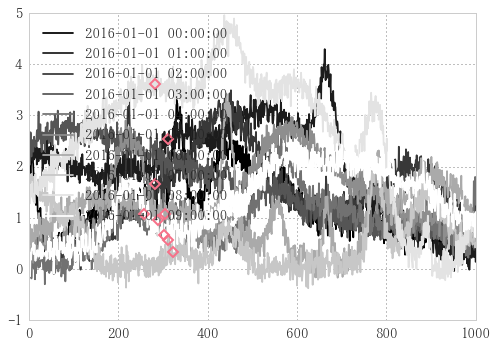

In [72]:
df.T.plot(cmap='gray')
plt_pnt_se.plot(style='D', mew=2, fillstyle='none')

## データフレームへのフィットを関数化

resultさえあれば何とかなるので、resultをreturnする関数にする。

In [103]:
def fit_df(df, center, span):
    param = a, mu, si = df[center].max(), center, 1
    ch = (center, span)  # dfからcenter,spanで取り出す
    dfe = df.apply(choice,axis=1, args=ch)  # 抜き出し
    fita = dfe.apply(fit, axis=1, args=param)  # フィッティング

    # フィッティング結果の整理
    result = np.array([i[0] for i in fita])  # タプルの第一要素だけを取り出しarray化
    return result

In [104]:
result = fit_df(df, 220, 200)
result

array([[  2.21691725e-01,   2.13580606e+02,   2.71176423e+01,
          1.12346093e+00],
       [  1.82872764e-01,   2.20590464e+02,   8.88599712e-01,
          1.98918253e+00],
       [  2.08159926e+00,   2.22439925e+02,   4.59234267e+00,
          1.08671082e+00],
       [ -5.75501049e-01,   2.19661573e+02,   2.67285120e-01,
          2.43258836e+00],
       [  1.84757841e+00,   2.57369440e+02,   1.19921676e+02,
         -7.69187238e-01],
       [  2.10001609e+00,   2.23559109e+02,   3.64246222e+01,
          5.40678934e-01],
       [  5.36912197e-01,   2.19109931e+02,  -1.06405484e-01,
          1.27381097e+00],
       [  2.84744125e-01,   2.20155924e+02,  -1.66996800e-01,
          1.56364664e-01],
       [  1.14160092e+00,   2.82278656e+02,   8.91448299e+01,
          2.47223917e+00],
       [  1.12007172e+00,   2.26628421e+02,   3.30471036e+01,
          5.07641118e-01]])

In [105]:
result = fit_df(df, 490, 200)
result

array([[  6.09632590e-01,   4.52668105e+02,   2.48124575e+01,
          1.80484274e+00],
       [  4.77719367e-01,   4.95913415e+02,   1.23812102e+00,
          2.86529818e+00],
       [  1.89850907e+00,   4.39608833e+02,   7.03684270e+01,
          1.20519337e+00],
       [ -5.44771364e+02,   6.12078520e+02,  -5.80921013e+03,
          5.46253682e+02],
       [ -2.04193375e+00,   4.31513618e+02,   6.49819855e+01,
          2.47084422e+00],
       [ -3.80628207e-02,   4.86058973e+02,  -8.13098381e-02,
          1.74054884e+00],
       [ -1.10854882e+00,   5.30669962e+02,   4.00563208e+01,
          1.65257657e+00],
       [ -2.28949421e-01,   4.89262561e+02,  -1.18327723e-01,
          2.71266524e-01],
       [ -1.16329706e-01,   4.88604118e+02,   1.23922372e+00,
          3.95875001e+00],
       [ -1.65863898e+00,   3.88161377e+02,   1.11774843e+02,
          2.62324782e+00]])

In [92]:
plt_pnt = np.apply_along_axis(defit, 1, result)  # ポイントのプロットに必要な部分抜き出し
plt_pnt_se = pd.Series(plt_pnt.T[1], index=plt_pnt.T[0])  # fitting結果をseries化

error 1 : Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


___

___

In [2]:
import sys
sys.path.append('../')

In [4]:
from fitclass import *

In [5]:
# giving initial parameters
mu = Parameter(7)
sigma = Parameter(3)
height = Parameter(5)

In [13]:
# define your function:
def f(x, h=height(), mu=mu(), si=sigma()): return h * np.exp(-((x-mu)/si)**2)

In [16]:
# fit! (given that data is an array with the data to fit)
data = 10*np.exp(-np.linspace(0, 10, 100)**2) + np.random.rand(100)
fitp, _ = fit(f, [mu, sigma, height], data); fitp

array([ -1.89549379,  12.09140583,  11.17214325])

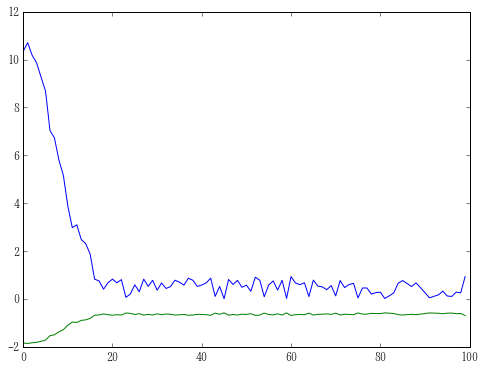

In [21]:
plt.plot(data)
plt.plot(f(data, *fitp))